In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from astropy.io import fits # Astropy for FITS files

# Custom functions
from cosmoforests.io import get_qso_data, get_docs_path
from cosmoforests.mask_forest import mask_forest
from cosmoforests.statistics import get_statistics

# Plot style
sns.set_theme()

# Data Directory (customize this)
data_dir = 'data/raw'

In [2]:
# Get the path to the FITS files in the data directory
fits_path = get_docs_path(data_dir)

Number of .fits files = 703
Path example: data/raw/13/1395/transmission-16-1395.fits.gz


## Working with only one .fits file

In [3]:
# Read in the first FITS file
hdul = fits.open(fits_path[0])

# File information
hdul.info()

# Close the FITS file
hdul.close()

Filename: data/raw/13/1395/transmission-16-1395.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  METADATA      1 BinTableHDU     23   3644R x 5C   [E, E, E, E, K]   
  2  WAVELENGTH    1 ImageHDU        11   (15150,)   float32   
  3  F_LYA         1 ImageHDU        12   (15150, 3644)   float32   
  4  F_LYB         1 ImageHDU        13   (15150, 3644)   float32   
  5  F_METALS      1 ImageHDU        14   (15150, 3644)   float32   
  6  DLA           1 BinTableHDU     23   1885R x 5C   [D, D, D, K, K]   


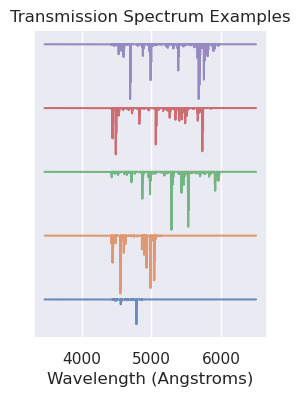

In [4]:
# Read in the first FITS file
z, wv, fluxes = get_qso_data(fits_path[0])

n_bins = len(wv)

# Create figure
fig, ax = plt.subplots(1, 1, figsize=(3, 4))

for i in range(5):
    ax.plot(wv, fluxes[i] + 1.1*i, alpha = 0.8)

ax.set_xlabel('Wavelength (Angstroms)')
# Remove the y-axis ticks and labels
ax.set_yticks([])
ax.set_yticklabels([])

# Plot title
ax.set_title('Transmission Spectrum Examples')

plt.show()

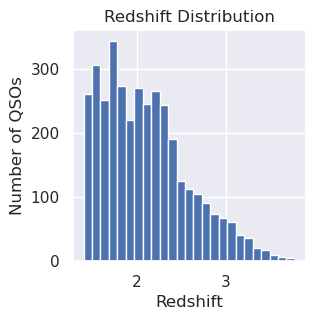

In [5]:
# Create figure
fig, ax = plt.subplots(1, 1, figsize=(3, 3))

ax.hist(z, bins = 25)
ax.set_xlabel('Redshift')
ax.set_ylabel('Number of QSOs')

ax.set_title('Redshift Distribution')
plt.show()

In [6]:
# Mask the flux data to a given wavelength range. Default to CIV forest.
fluxes = mask_forest(z, wv, fluxes)

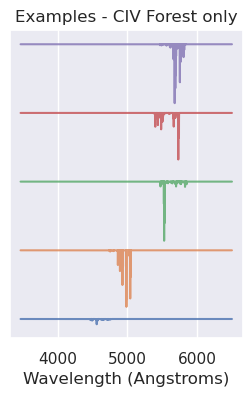

In [7]:
# Create figure
fig, ax = plt.subplots(1, 1, figsize=(3, 4))

for i, flux in enumerate(fluxes[0:5]):
    ax.plot(wv, flux + 1.1*i, alpha = 0.8)

ax.set_xlabel('Wavelength (Angstroms)')
# Remove the y-axis ticks and labels
ax.set_yticks([])
ax.set_yticklabels([])

# Plot title
ax.set_title('Examples - CIV Forest only')

plt.show()

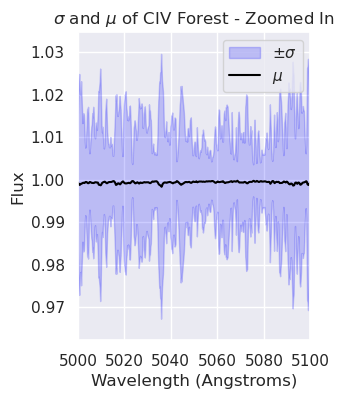

In [9]:
# Get statistics for the transmission files.
mean, std, deltas = get_statistics(fluxes)

# Create figure
fig, ax = plt.subplots(1, 1, figsize=(3, 4))

# Plot standard deviation
ax.fill_between(wv, mean - std, mean + std,
                alpha = 0.2, color = 'blue',
                label = '$\pm \sigma$')

# Plot mean
ax.plot(wv, mean, alpha = 1, color = 'black',
        label = '$\mu$')

# Zoom in on the CIV forest
ax.set_xlim(5000, 5100)

# Labels
ax.set_xlabel('Wavelength (Angstroms)')
ax.set_ylabel('Flux')
ax.set_title('$\sigma$ and $\mu$ of CIV Forest - Zoomed In')

# Show legend
ax.legend()

plt.show()

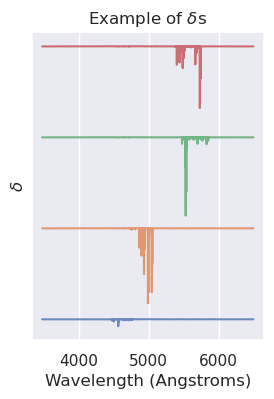

In [16]:
# Create figure
fig, ax = plt.subplots(1, 1, figsize=(3, 4))

for i, delta in enumerate(deltas[0:4]):
    ax.plot(wv, delta + 1.1*i, alpha = 0.8)

ax.set_xlabel('Wavelength (Angstroms)')
ax.set_ylabel('$\delta$')

# Remove the y-axis ticks and labels
ax.set_yticks([])
ax.set_yticklabels([])

# Plot title
ax.set_title('Example of $\delta$s')

plt.show()